In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset, repeat_channels
from metrics import compute_metrics
from training import train
from torch.utils.data._utils.collate import default_collate
from sklearn.model_selection import train_test_split, KFold

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [3]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.0  # overlap between consecutive windows



indices = np.arange(94)
# split the dataset into train and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices:", train_indices)
print("Val indices:", val_indices)

train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                   file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                   overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_indices)
val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)

Train indices: [65 15 68 78 30 33 11 66 69 31 77  9 70  5 42 47 16 45 34  7 80 27 19 76
 25 53 13 24  3 17 38  8 73  6 89 36 87 56 93 54 43 50 75 46 64 61 91 84
 41 58 48 81 57 32 88 59 63 79 37 29  1 52 21  2 23 85 74 86 82 20 60 71
 14 92 51]
Val indices: [40 22 55 72  0 26 39 67 10 44 83 35 90 62 12  4 18 28 49]


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 200)
Total number of windows = 966
Number of unique IDs = 966


Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 200)
Total number of windows = 259
Number of unique IDs = 259


In [4]:
j = 0
for i in range(len(train_loader.dataset) - 1):
    j += train_loader.dataset[i]['label']
pos_proportion = j / len(train_loader.dataset)
print(f"proportion of positive samples in train set: {pos_proportion.item():.3%}, {1/pos_proportion.item():.3f}")

proportion of positive samples in train set: 17.288%, 5.784


In [5]:
# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True)

# replace classifier layer for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 640),  # output one value
    nn.ReLU(),
    nn.Linear(640, 1),
)

#summary(model.to('cuda'), (3, 224, 224))

In [8]:
num_epochs = 7

criterion = nn.BCEWithLogitsLoss()  #os_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=25)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

training on device 'cuda'


Epoch 0:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.94076, f1: 0.86122, roc-auc: 1.00000
            Test accuracy: 0.86562, f1: 0.51696, roc-auc: 0.95034


Epoch 1:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.97070, f1: 0.91864, roc-auc: 1.00000
            Test accuracy: 0.89062, f1: 0.55121, roc-auc: 0.95117


Epoch 2:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.99609, f1: 0.98804, roc-auc: 1.00000
            Test accuracy: 0.91563, f1: 0.58678, roc-auc: 0.95775


Epoch 3:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 0.93750, roc-auc: 1.00000
            Test accuracy: 0.92500, f1: 0.59459, roc-auc: 0.95591


Epoch 4:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 1.00000, roc-auc: 1.00000
            Test accuracy: 0.93750, f1: 0.63862, roc-auc: 0.95662


Epoch 5:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 1.00000, f1: 1.00000, roc-auc: 1.00000
            Test accuracy: 0.94063, f1: 0.62883, roc-auc: 0.95384


Epoch 6:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 1.00000, f1: 1.00000, roc-auc: 1.00000
            Test accuracy: 0.93750, f1: 0.63862, roc-auc: 0.95490


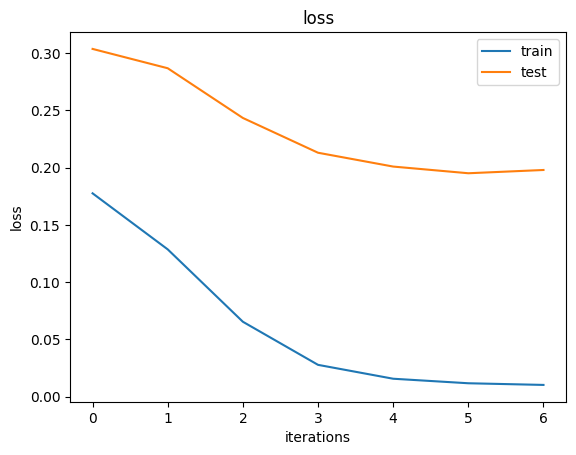

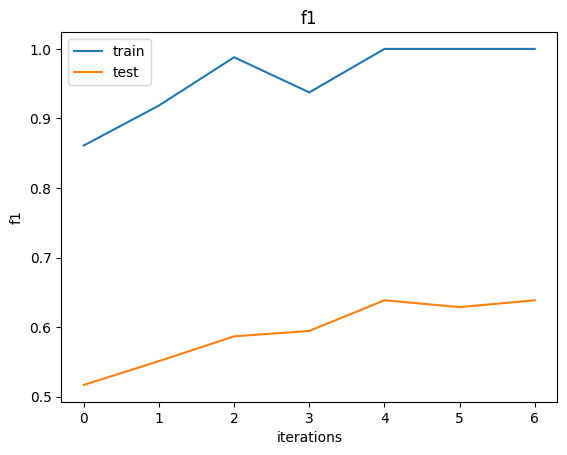

(1.0, 0.6386222473178995)

In [9]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=num_epochs)